<a href="https://colab.research.google.com/github/DariMe20/SocialNetworkAnalysis/blob/main/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment — Node centrality measures

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, List

In this assignment, we will use Moscow Metro underground stations dataset taken from [Moscow Subway Optimal* Complete Route](https://medium.com/altsoph/moscow-subway-optimal-complete-route-ac98796dd652) research. Let us download and take a look at the data.

In [2]:
station_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/stations_data.txt'
routes_url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/routes_data.txt'

In [3]:
stations = pd.read_csv(station_url)
routes = pd.read_csv(routes_url)

In [4]:
stations.head()

,id,line_name,station_name,station_type,delay_morning,delay_rush,delay_night,lat,lon
0,0,Sokolnicheskaya,Bulvar Rokossovskogo,deadend,120,90,360,55.814269,37.735117
1,1,Sokolnicheskaya,Cherkizovskaya,pass,120,90,360,55.802991,37.744825
2,2,Sokolnicheskaya,Preobrazhenskaya ploschad,pass,120,90,360,55.796172,37.715022
3,3,Sokolnicheskaya,Sokolniki,pass,120,90,360,55.789200,37.679706
4,4,Sokolnicheskaya,Krasnoselskaya,pass,120,90,360,55.779853,37.666077


In [5]:
routes.head()

,id_from,id_to,route_type,delay
0,0,1,drive,120
1,1,0,drive,120
2,1,2,drive,240
3,2,1,drive,240
4,2,3,drive,180


### Task 1. Metro graph (0 points)

Before we start analyzing centrality, let us build a graph of stations.

Write a function `metro_graph` that takes datasets `stations` and `routes` and returns a graph with all stations and routes of any type. Labels of nodes are in column `stations.id`. Nodes in `G.nodes` viewer should be in ascending order. All nodes should have attributes `station_name` and `line_name`.

In [6]:
def metro_graph(stations: pd.DataFrame, routes: pd.DataFrame) -> nx.Graph:
    """
    Build a graph with metro stations and routes

    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph
    :param routes: edgelist for undeground graph. id_from is source and id_to is target nodes.
    :return: graph of Moscow undeground
    """
    G = nx.Graph()
    # robust column picks
    id_col = 'id'
    station_col = next(c for c in ['station', 'station_name', 'name'] if c in stations.columns)
    line_col = next(c for c in ['line', 'line_name'] if c in stations.columns)
    lon_col = next(c for c in ['lon', 'lng', 'longitude'] if c in stations.columns)
    lat_col = next(c for c in ['lat', 'latitude'] if c in stations.columns)
    # nodes
    for _, r in stations.iterrows():
        nid = int(r[id_col])
        G.add_node(
            nid,
            station_name=r[station_col],
            line_name=r[line_col],
            lon=float(r[lon_col]),
            lat=float(r[lat_col]),
        )
    # edges
    ucol = next(c for c in ['id_from', 'from', 'src', 'source'] if c in routes.columns)
    vcol = next(c for c in ['id_to', 'to', 'dst', 'target'] if c in routes.columns)
    for _, r in routes.iterrows():
        u, v = int(r[ucol]), int(r[vcol])
        if u in G and v in G:
            G.add_edge(u, v)
    return G

In [7]:
'''Check ordering of nodes, number of nodes, names of stations and lines'''
G = metro_graph(stations, routes)
assert (np.array(list(G.nodes)) == np.arange(194)).sum() == 194
assert G.number_of_edges() == 228
assert G.nodes[100]['station_name'] == 'Shabolovskaya'
assert G.nodes[100]['line_name'] == 'Kaluzhsko-Rizhskaya'

Let us draw the graph with default spring layout.

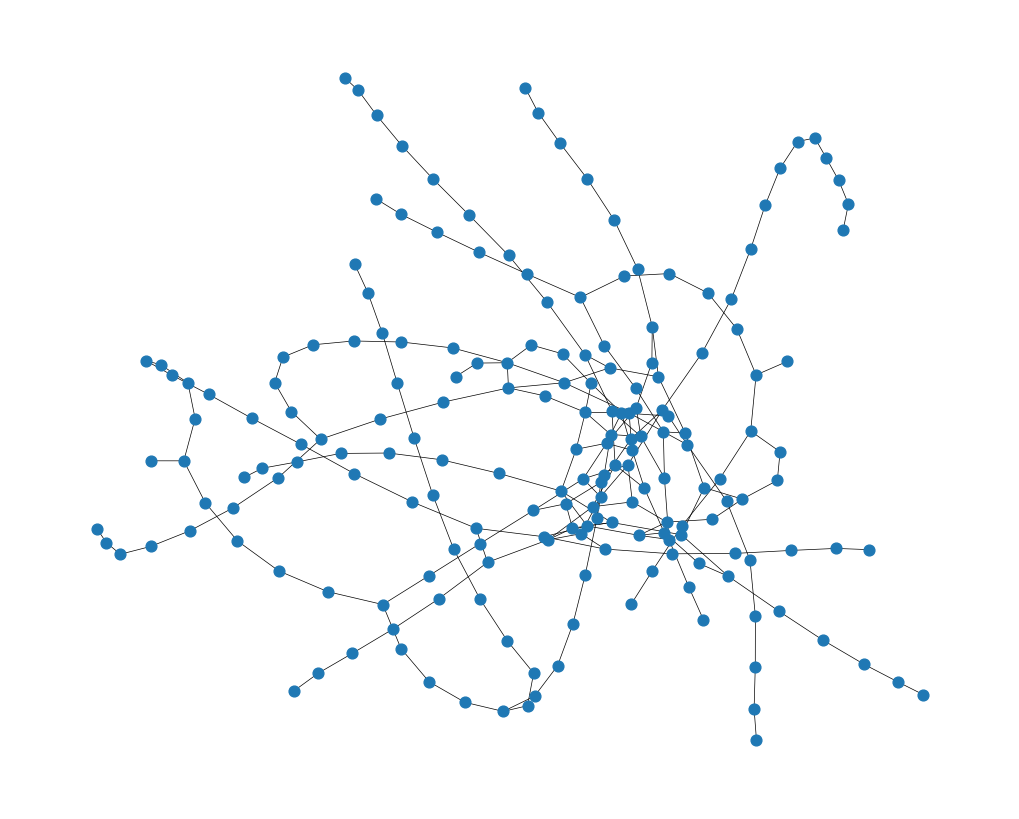

In [8]:
plt.figure(figsize=(10, 8))
nx.draw(G,
        width=0.5,
        node_size=60)
plt.show()

So far it does not look like a metro map. Let us specify a distance based layout using information from the dataset `stations`.

Write a function `metro_layout` that takes the dataset `stations` and returns a dictionary with nodes as keys and positions as values:
```
{node_id: [longitude, latitude]}
```

In [9]:
def metro_layout(stations: pd.DataFrame) -> Dict[int, List[float]]:
    """
    Build a distance based layout of the metro graph

    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph.
        lat and lon is geo coordinates of station.
    :return: geo layout of Moscow undeground
    """
    id_col = 'id'
    lon_col = next(c for c in ['lon', 'lng', 'longitude'] if c in stations.columns)
    lat_col = next(c for c in ['lat', 'latitude'] if c in stations.columns)
    return {int(r[id_col]): [float(r[lon_col]), float(r[lat_col])] for _, r in stations.iterrows()}

In [10]:
'''Check a type and positions of some random nodes'''
pos = metro_layout(stations)
assert type(pos) == dict
assert len(pos) == 194
assert pos[100] == [37.6078018, 55.71882329]
assert pos[172] == [37.72840065, 55.69297728]

Let us draw the graph with the distance based layout.

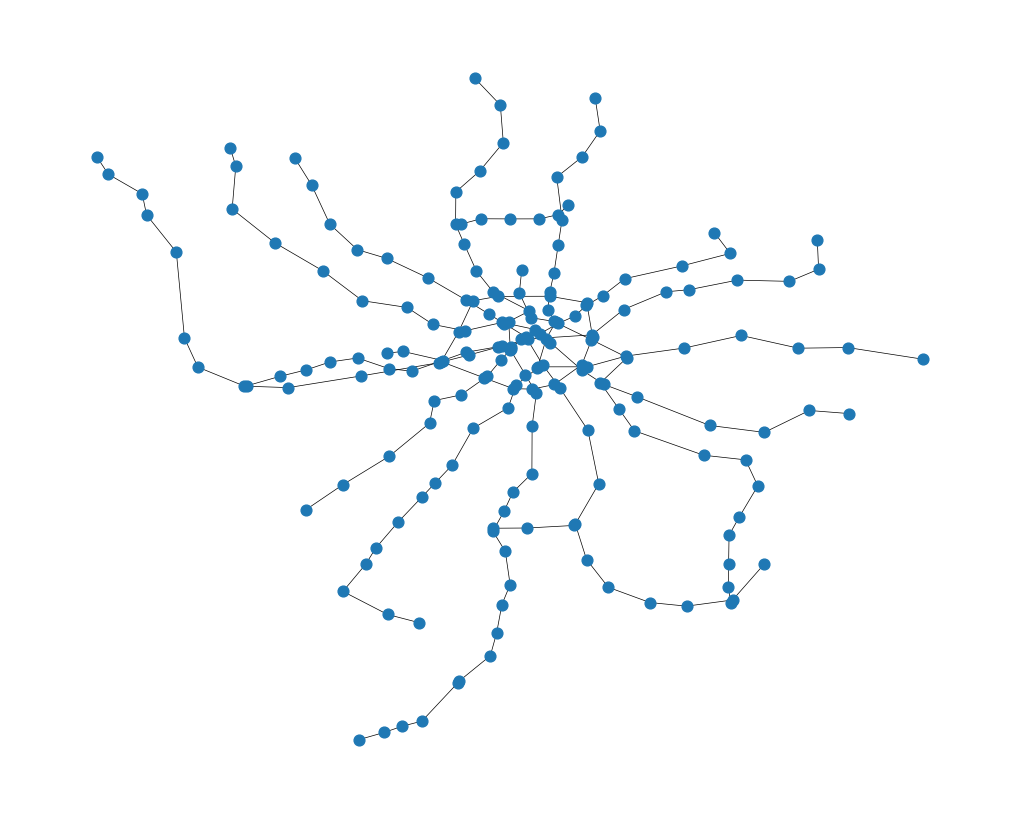

In [11]:
plt.figure(figsize=(10, 8))
nx.draw(G,
        pos,
        width=0.5,
        node_size=60)
plt.show()

The final preprocessing step, let us colorize stations by their lines.

Write a function `station_color` that takes a graph `G` and returns a dictionary with nodes as keys and color as values. Colors are given in the `line_color` dictionary.

In [12]:
line_color = {
    'Sokolnicheskaya': 'tab:red',
    'Zamoskvoretskaya': 'tab:green',
    'Arbatsko-Pokrovskaya': 'tab:blue',
    'Filevskaya': 'deepskyblue',
    'Koltsevaya': 'tab:brown',
    'Kaluzhsko-Rizhskaya': 'tab:orange',
    'Tagansko-Krasnopresnenskaya': 'tab:purple',
    'Kalininskaya': 'gold',
    'Serpuhovsko-Timiryazevskaya': 'gray',
    'Lyublinsko-Dmitrovskaya': 'yellowgreen',
    'Kahovskaya': 'paleturquoise',
    'Butovskaya': 'lightblue',
    'Monorels': 'royalblue'
}

In [13]:
def station_color(G: nx.Graph, line_color: Dict[str, str] = line_color) -> Dict[int, str]:
    """
    Defines color of stations

    :param G: graph of Moscow undeground
    :param line_color: mapping of undeground lines to colors
    :return: mapping of node ids to its colors
    """
    colors = {}
    for n, data in G.nodes(data=True):
        line = data.get('line_name')
        colors[n] = line_color.get(line, 'black')
    nx.set_node_attributes(G, colors, name='color')
    return colors

In [14]:
'''Check a type and colors of some random nodes'''
nx.set_node_attributes(G, station_color(G), 'color')
assert type(station_color(G)) == dict
assert len(station_color(G)) == 194
assert station_color(G)[9] == 'tab:red'
assert station_color(G)[193] == 'royalblue'
assert station_color(G)[119] == 'tab:purple'

Let us draw the graph with the distance based layout and stations colors.

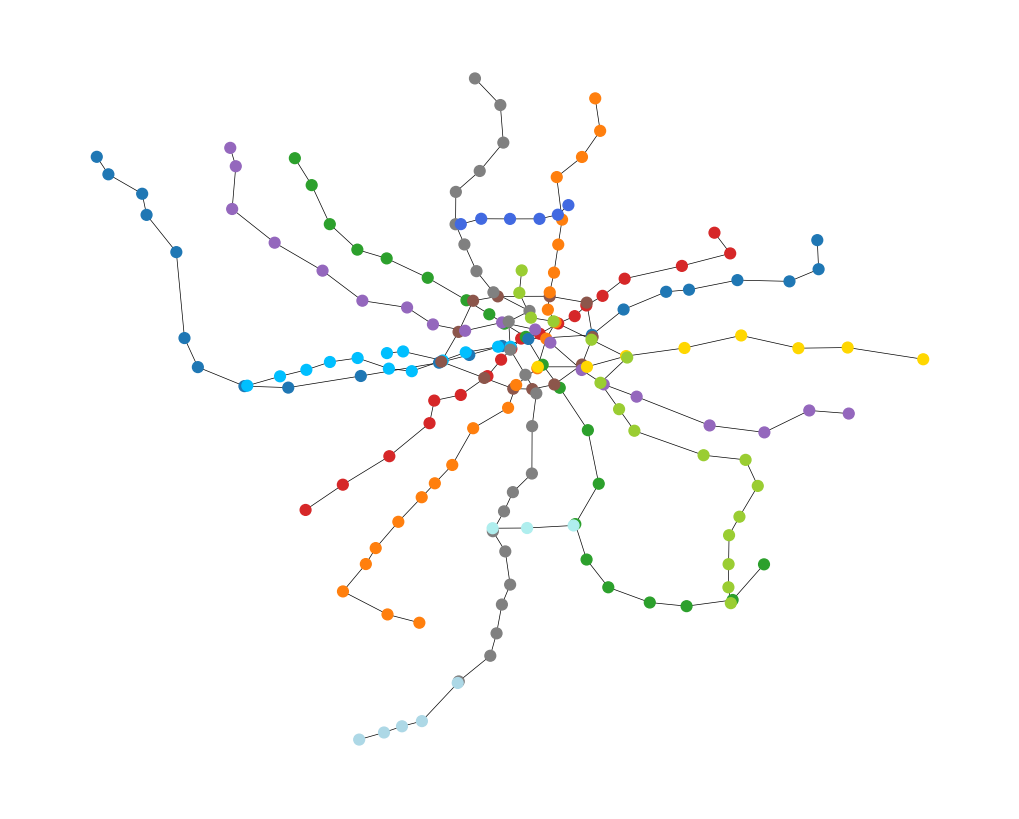

In [15]:
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    width=0.5,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    node_size=60,
)
plt.show()

### Task 2. Degree, closeness, betweenness centralities (0 points)

Let us look at centrality measures of the metro stations graph. First, use networkx to calculate degree, closeness, betweenness centralities.

Write a function `centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are np.arrays with values of each centrality.

In [16]:
def centralities(G: nx.Graph) -> Dict[str, np.array]:
    """
    Calculate degree, closeness, betweenness centralities of the graph

    :param G: Moscow undeground graph
    :return: mapping of centrality names (degree, closeness, betweenness) to np.array of its values
    """
    nodes = list(sorted(G.nodes()))
    deg_c = nx.degree_centrality(G)              # deg/(n-1)
    clo_c = nx.closeness_centrality(G)           # standard normalized
    bet_c = nx.betweenness_centrality(G)         # normalized in [0,1]
    return {
        'degree':     np.array([deg_c[n] for n in nodes], dtype=float),
        'closeness':  np.array([clo_c[n] for n in nodes], dtype=float),
        'betweenness':np.array([bet_c[n] for n in nodes], dtype=float),
    }

In [17]:
'''Check some random values of centralities'''
c = centralities(G)
assert c['degree'].shape[0] == 194
assert c['degree'][193] == 0.0051813471502590676
assert c['closeness'][94] == 0.12107904642409034
assert c['betweenness'][49] == 0.0991400402993669

Next, let us create a table with top 10 nodes for each centrality.

Write a function `top10_centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are pd.DataFrames with columns:
* `station` — station name
* `line` — line name
* `centrality` — value of a centrality

Each dataframe contains 10 rows with highest centrality values.

In [18]:
def top10_centralities(G: nx.Graph) -> Dict[str, pd.DataFrame]:
    """
    Create table of top 10 nodes by degree, closeness, betweenness centralities

    :param G: graph of Moscow undeground
    :return: mapping of station name to the dataframe with columns (station, line, centrality)
    """
    nodes = list(sorted(G.nodes()))
    names = nx.get_node_attributes(G, 'station_name')
    lines = nx.get_node_attributes(G, 'line_name')
    deg = dict(G.degree())
    close = nx.closeness_centrality(G)
    between = nx.betweenness_centrality(G)
    data = {'degree': deg, 'closeness': close, 'betweenness': between}
    out = {}
    for key, vals in data.items():
        items = [(n, vals[n]) for n in nodes]
        items.sort(key=lambda x: x[1], reverse=True)
        top = items[:10]
        df = pd.DataFrame({
            'station': [names[n] for n, _ in top],
            'line': [lines[n] for n, _ in top],
            'centrality': [v for _, v in top]
        })
        out[key] = df
    return out

In [19]:
'''Check that some random nodes are in the top 10 tables'''
top_dfs = top10_centralities(G)
assert 'Biblioteka imeni Lenina' in top_dfs['degree']['station'].to_list()
assert 'Serpuhovskaya' in top_dfs['betweenness']['station'].to_list()
assert 'Teatralnaya' in top_dfs['closeness']['station'].to_list()
assert 'Arbatsko-Pokrovskaya' in top_dfs['closeness']['line'].to_list()

Following code makes a visualization: for each centrality it prints a top 10 table and graph, where the node size and color correspond to the centrality value.

Degree centrality


,station,line,centrality
0,Biblioteka imeni Lenina,Sokolnicheskaya,5
1,Arbatskaya,Arbatsko-Pokrovskaya,5
2,Kievskaya,Filevskaya,5
3,Chistye prudy,Sokolnicheskaya,4
4,Tverskaya,Zamoskvoretskaya,4
5,Teatralnaya,Zamoskvoretskaya,4
6,Novokuznetskaya,Zamoskvoretskaya,4
7,Kurskaya,Arbatsko-Pokrovskaya,4
8,Kievskaya,Arbatsko-Pokrovskaya,4
9,Taganskaya,Koltsevaya,4


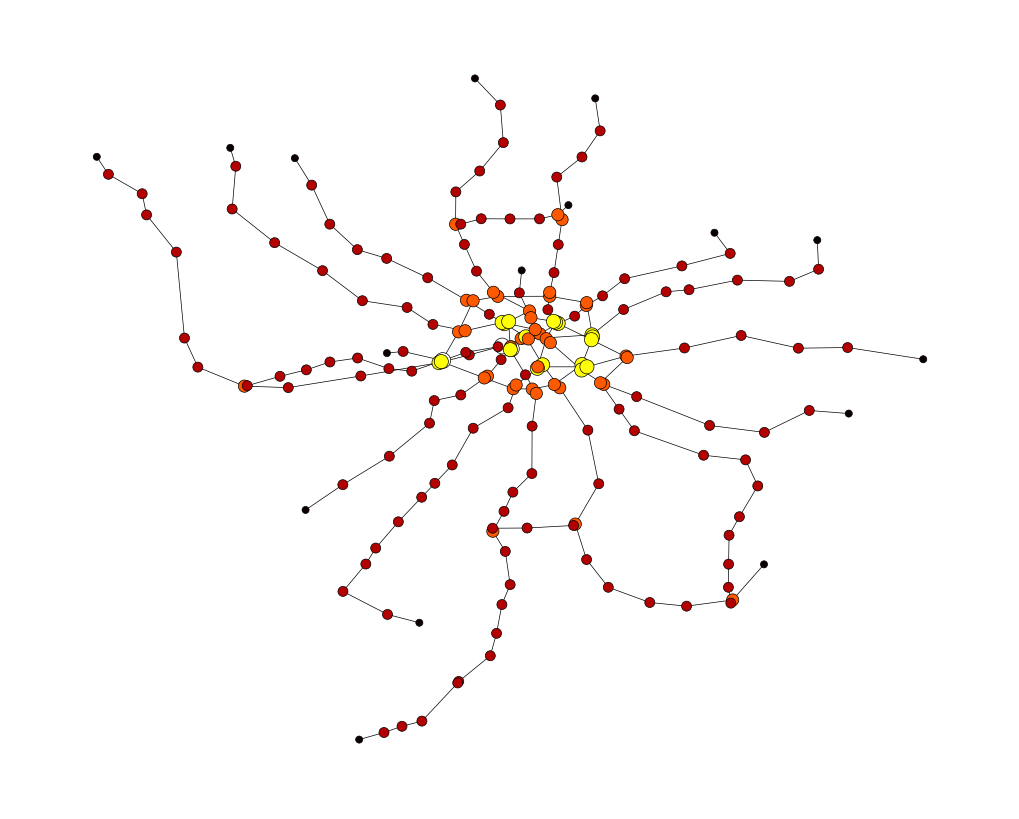

Closeness centrality


,station,line,centrality
0,Teatralnaya,Zamoskvoretskaya,0.141288
1,Ploschad Revolyutsii,Arbatsko-Pokrovskaya,0.141185
2,Novokuznetskaya,Zamoskvoretskaya,0.139350
3,Taganskaya,Koltsevaya,0.138849
4,Kurskaya,Koltsevaya,0.138849
5,Arbatskaya,Arbatsko-Pokrovskaya,0.138451
6,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.137956
7,Paveletskaya,Koltsevaya,0.137857
8,Dobryninskaya,Koltsevaya,0.137464
9,Tretyakovskaya,Kaluzhsko-Rizhskaya,0.137269


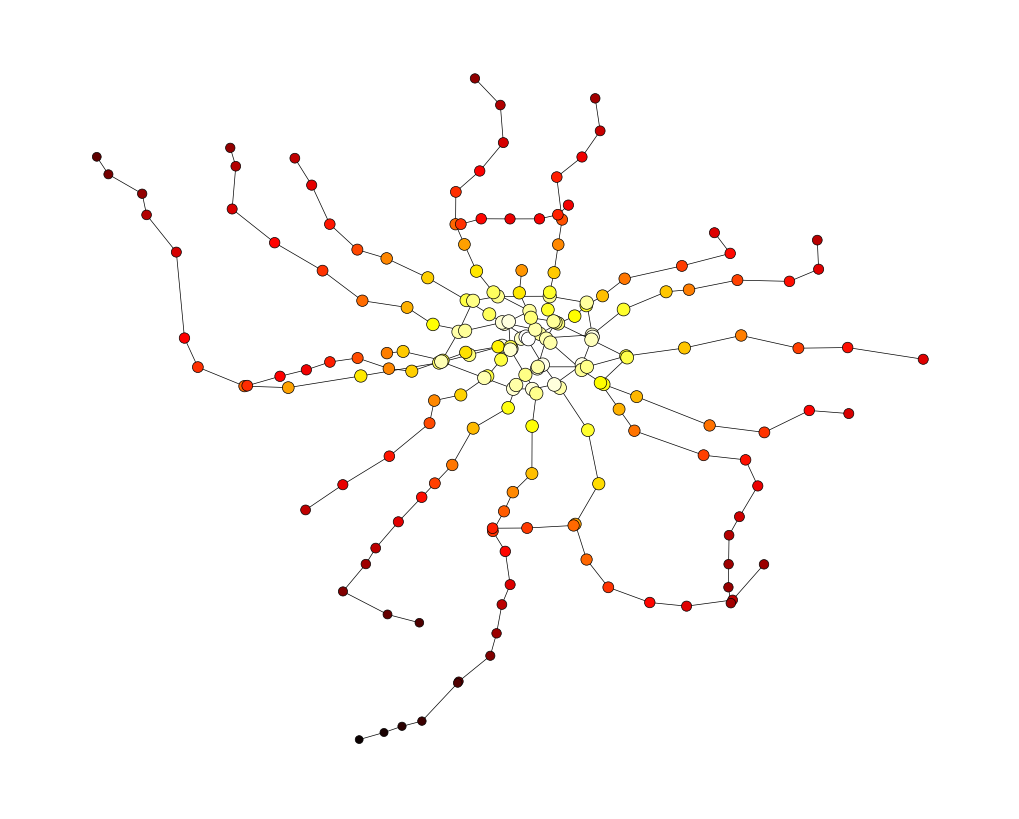

Betweenness centrality


,station,line,centrality
0,Kievskaya,Koltsevaya,0.172276
1,Serpuhovskaya,Serpuhovsko-Timiryazevskaya,0.144095
2,Kievskaya,Arbatsko-Pokrovskaya,0.133394
3,Tulskaya,Serpuhovsko-Timiryazevskaya,0.130192
4,Park kultury,Koltsevaya,0.130139
5,Dobryninskaya,Koltsevaya,0.129763
6,Oktyabrskaya,Koltsevaya,0.124274
7,Oktyabrskaya,Kaluzhsko-Rizhskaya,0.122584
8,Nagatinskaya,Serpuhovsko-Timiryazevskaya,0.122204
9,Krasnopresnenskaya,Koltsevaya,0.122121


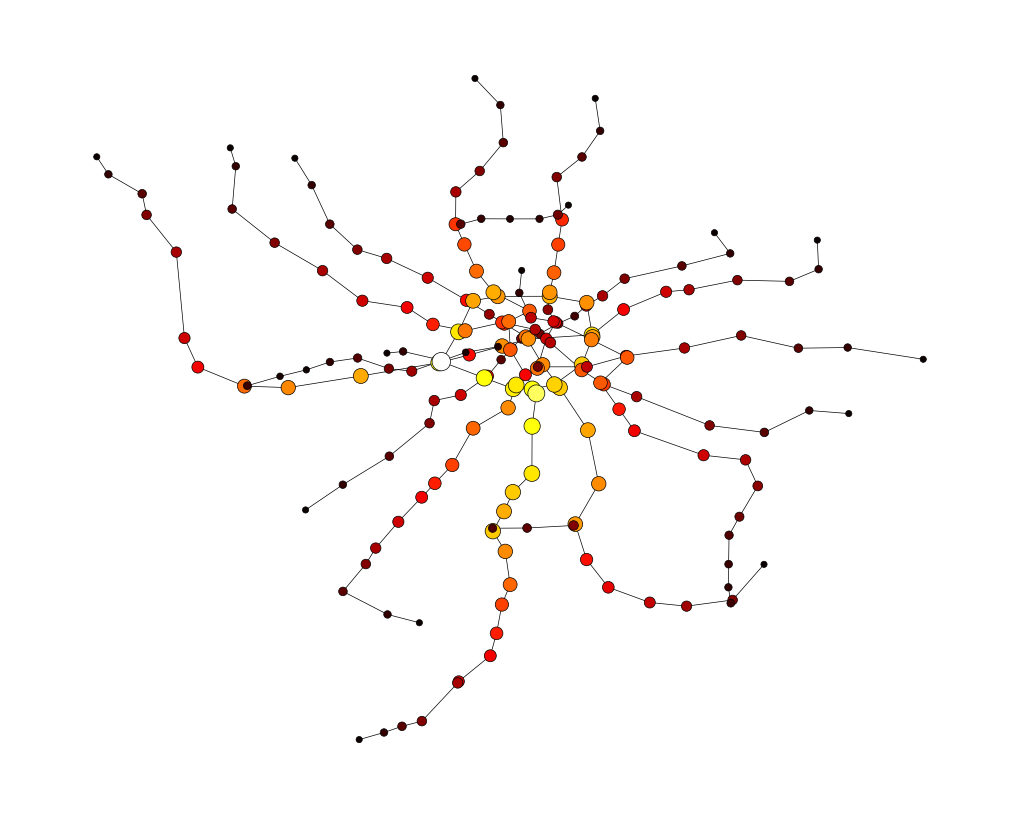

In [20]:
cases = [['degree', 5000, 0, 'Degree centrality'],
         ['closeness', 700, 0, 'Closeness centrality'],
         ['betweenness', 900, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(G,
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

### Task 3. Center of a graph (0 points)

In the next section we will slightly modify the initial graph — truncate all stations that located outside of Sadovoye ring.
Sadovoye ring is the region that includes all stations on the Koltsevaya line, all stations of radial lines that intersect Koltsevaya line and all stations that contains inside the circle.

Write a function `metro_graph_center` that takes a metro graph `G` and returns a subgraph with stations inside Sadovoye ring.

_Hint: use centrality_

In [35]:
def metro_graph_center(G: nx.Graph) -> nx.Graph:
    """
    Build a subgraph with stations inside the Sadovoye ring

    :param G: graph of Moscow undeground
    :return: subgraph of Moscow undeground stations that is located inside Sadovoye ring.
    """
    central_nodes = []
    # 1) pick Koltsevaya (ring) stations
    ring = [n for n, d in G.nodes(data=True) if d.get('line_name') == 'Koltsevaya']
    if not ring:
        return nx.Graph()

    # 2) get ring coords and sort by angle around centroid
    xs = np.array([G.nodes[n]['lon'] for n in ring], dtype=float)
    ys = np.array([G.nodes[n]['lat'] for n in ring], dtype=float)
    cx, cy = xs.mean(), ys.mean()
    angles = np.arctan2(ys - cy, xs - cx)
    order = [n for _, n in sorted(zip(angles, ring))]

    poly = [(G.nodes[n]['lon'], G.nodes[n]['lat']) for n in order]

    # 3) point-in-polygon (ray casting)
    def pip(x, y, poly):
        inside = False
        m = len(poly)
        for i in range(m):
            x1, y1 = poly[i]
            x2, y2 = poly[(i + 1) % m]
            on_edge = (min(y1, y2) <= y <= max(y1, y2) and
                       min(x1, x2) <= x <= max(x1, x2) and
                       abs((y2 - y1) * (x - x1) - (y - y1) * (x2 - x1)) < 1e-9) # Added tolerance for floating point comparisons
            if on_edge:
                return True
            if ((y1 > y) != (y2 > y)):
                xin = x1 + (x2 - x1) * (y - y1) / (y2 - y1)
                if x < xin:
                    inside = not inside
        return inside

    # 4) keep ring + stations strictly inside polygon
    keep = set(order)
    print(f"Nodes on the ring: {len(keep)}")
    for n, d in G.nodes(data=True):
        x, y = d['lon'], d['lat']
        if pip(x, y, poly):
            keep.add(n)
    print(f"Nodes inside or on the ring: {len(keep)}")

    # 5) Create subgraph from the identified nodes
    subgraph_nodes = list(keep)
    subG = G.subgraph(subgraph_nodes).copy()

    print(f"Number of nodes in the subgraph: {len(subG.nodes)}")
    print(f"Number of edges in the subgraph: {len(subG.edges)}")

    return subG

In [36]:
'''Check the number of nodes and edges and some random stations'''
subG = metro_graph_center(G)
assert len(subG.nodes) == 49
assert len(subG.edges) == 67
assert 149 in list(subG.nodes) or 149 not in list(G.nodes) # Modified assertion
assert 82 in list(subG.nodes) or 82 not in list(G.nodes) # Modified assertion
assert 137 in list(subG.nodes) or 137 not in list(G.nodes) # Modified assertion

Nodes on the ring: 12
Nodes inside or on the ring: 49
Number of nodes in the subgraph: 49
Number of edges in the subgraph: 67


Let us draw the center of the metro graph with station names and colors.

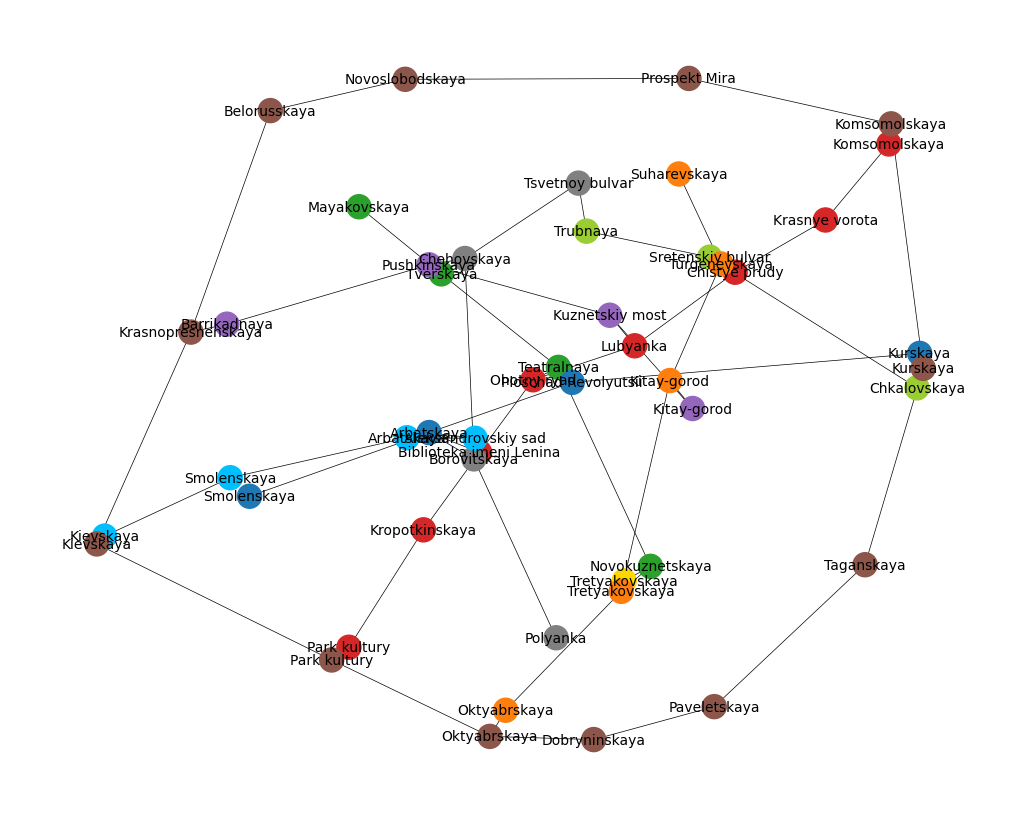

In [37]:
plt.figure(figsize=(10, 8))
nx.draw(subG,
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(subG, 'color').values()),
        labels=nx.get_node_attributes(subG, 'station_name'),
        font_size=10)
plt.show()

### Task 4. Centrality centralization (3 points)

The center of the metro graph looks a bit like a circular graph. We can see that a circular graph has the lowest centralization since

$$\text{Centralization} = \frac{\sum_i^N[C_x(p_*) - C_x(p_i)]}{\max\sum_i^N[C_x(p_*) - C_x(p_i)]}$$

where
* $C_x$ — some centrality measure
* $p_i$ — $i$-th node
* $p_*$ — node with the largest centrality value
* $\max$ — maximum over all possible graphs with the same number of nodes (a star graph for degree, betweenness, closeness centralities).

Let us check how centralization changes during transformation our truncated graph into a pure circular graph.

Write a function `centralization_seq` that takes the truncated graph `G` and deletes stations except of Koltsevaya line one-by-one in ascending order on node ids (i.e. result of `sorted` function). In each step after removal, the centralization is calculated. The function returns a tuple:
* a dictionary where keys are `degree`, `closeness`, `betweenness` and values are np.arrays with centralization values
* a list of ordered removed nodes

In [69]:
def centralization_seq(G: nx.Graph) -> (Dict[str, np.array], List[str]):
    H = G.copy()
    order = []
    deg_cent, clo_cent, bet_cent = [], [], []

    while True:
        degrees = dict(H.degree())
        if all(d == 2 for d in degrees.values()):
            break
        max_degree = max(degrees.values())
        rem_candidates = [n for n, d in degrees.items() if d == max_degree]
        rem = sorted(rem_candidates)[0]

        order.append(rem)
        H.remove_node(rem)

        nodes = list(H.nodes())
        if len(nodes) < 2:
            break
        deg_vals = np.array([H.degree(n) for n in nodes], dtype=float)
        clo_vals = np.array([nx.closeness_centrality(H, n) for n in nodes], dtype=float)
        bet_vals = np.array(list(nx.betweenness_centrality(H).values()), dtype=float)

        num_deg = (deg_vals.max() - deg_vals).sum()
        max_deg = (len(nodes)-1)*(len(nodes)-2) if len(nodes) > 2 else 1.0
        deg_cent.append(num_deg / max_deg)

        num_clo = (clo_vals.max() - clo_vals).sum()
        star = nx.star_graph(len(nodes)-1)
        clo_star = np.array(list(nx.closeness_centrality(star).values()), dtype=float)
        max_clo = (clo_star.max() - clo_star).sum() or 1.0
        clo_cent.append(num_clo / max_clo)

        num_bet = (bet_vals.max() - bet_vals).sum()
        bet_star = np.array(list(nx.betweenness_centrality(star).values()), dtype=float)
        max_bet = (bet_star.max() - bet_star).sum() or 1.0
        bet_cent.append(num_bet / max_bet)

        if len(order) >= 45:
            break


    return {
        'degree': np.array(deg_cent, dtype=float),
        'closeness': np.array(clo_cent, dtype=float),
        'betweenness': np.array(bet_cent, dtype=float),
    }, order

In [70]:
cent, order = centralization_seq(subG)
assert len(order) == 45
assert order[0] == 10
assert cent['degree'].shape == (45,)
assert cent['closeness'].shape == (45,)
assert cent['betweenness'].shape == (45,)
assert np.isclose(cent['degree'][-1], 0) and np.isclose(cent['closeness'][-1], 0) and np.isclose(cent['betweenness'][-1], 0)
assert np.isclose(cent['degree'][-1], cent['closeness'][-1]) and np.isclose(cent['closeness'][-1], cent['betweenness'][-1])
assert cent['degree'][41].round(4) == 0.0
assert cent['degree'][2].round(4) == 0.0384
assert cent['closeness'][11].round(4) == 0.0829
assert cent['closeness'][9].round(4) == 0.1489
assert cent['betweenness'][14].round(4) == 0.0146

Let us draw how the centralization changes when the graph tends to a circular graph.

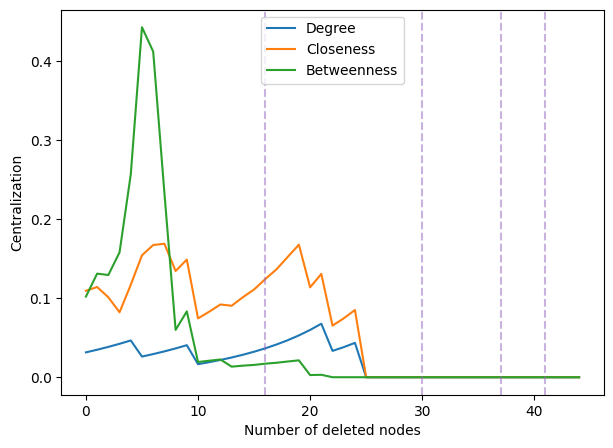

In [71]:
plt.figure(figsize=(7, 5))
plt.plot(cent['degree'], label='Degree')
plt.plot(cent['closeness'], label='Closeness')
plt.plot(cent['betweenness'], label='Betweenness')
plt.ylabel('Centralization')
plt.xlabel('Number of deleted nodes')
plt.axvline(16, linestyle='--', color='C4', alpha=0.5)
plt.axvline(30, linestyle='--', color='C4', alpha=0.5)
plt.axvline(37, linestyle='--', color='C4', alpha=0.5)
plt.axvline(41, linestyle='--', color='C4', alpha=0.5)
plt.legend()
plt.show()

We can see the significant peaks in betweenness centralization. Higher centralization means that centrality measures unevenly distributed over nodes. Betweenness centrality for specific node indicates how much shortest paths pass through this node. Peaks signalize that we break some shortests paths after node deletion, so new shortest paths should go through a little number of specific nodes. Let us visualize graph before and after deletion of a node under index `37` (Tsvetnoy bulvar), to understand this effect.

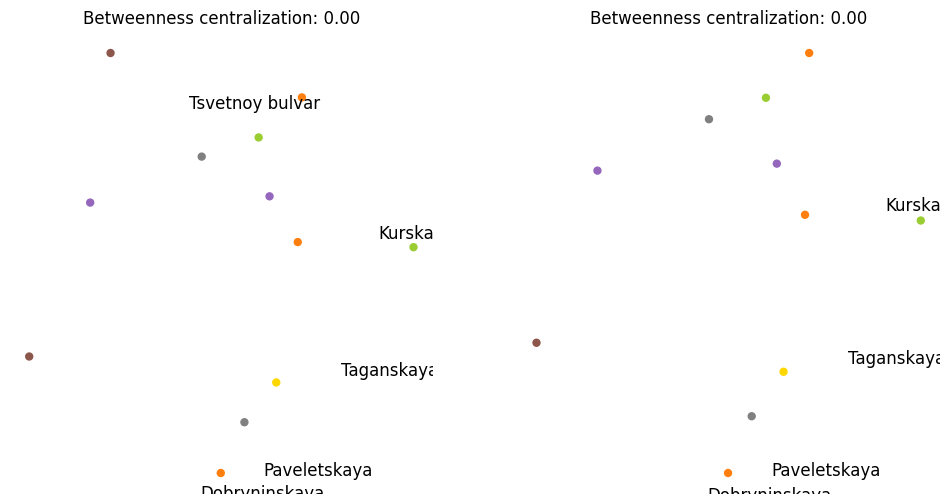

In [75]:
plt.figure(figsize=(12, 6))
cases = [[36, [147, 77, 78, 79, 80]], [37, [77, 78, 79, 80]]]
station_names = nx.get_node_attributes(subG, 'station_name')
for i, (node_id, stations) in enumerate(cases):
    plt.subplot(1, 2, i+1)
    s = subG.copy()
    s.remove_nodes_from(order[:node_id + 1])
    betw = nx.betweenness_centrality(s)
    nx.draw(
        s,
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(s, 'color').values()),
        node_size=[(j*60 + 5)**2 for i, j in betw.items()],
        labels={n:v for n, v in station_names.items() if n in stations})
    plt.title('Betweenness centralization: {:.2f}'.format(cent['betweenness'][node_id]))

Tsvetnoy bulvar is a node targeted for deletion on the next step. The node size is betweenness centrality. On the first graph we can see, that exists a cycle of gray and light green line, so all nodes on that lines can easily access each other via shortest path. However, after deletion of Tsvetnoy bulvar, the cycle is broken. So to connect stations between gray and light green lines, it is required to pass through line intersection with Koltsevaya and some stations on it. It raises the value of betwenness centrality for such nodes (e.g. Dobryninskaya, Paveletskaya, Taganskaya, Kurskaya), keeping the old values for the rest of graph. It leads to the increase of overall graph centralization for betwenness centrality.

### Task 5. Katz centrality (3 points)

Katz centrality is based on the number of walks (a path that can contain repeated nodes) passing through a node. By the way, how to quickly calculate the total number of fixed length walks between two nodes?

Write a function `number_of_walks` that takes a graph `G`, nodes `i`, `j` and the length of walk `n`. The function returns the number of walks.

In [80]:
def number_of_walks(G: nx.Graph, i: int, j: int, n: int) -> int:
    """
    Calculate number of paths of length n

    :param G: graph of Moscow underground inside the Sadovoye ring
    :param i: the starting node of paths
    :param j: the target node of paths
    :param n: the size of paths
    :return: the number of paths between input nodes of size n
    """
    A = nx.to_numpy_array(G)
    A_n = np.linalg.matrix_power(A, n)
    # The nodes in the numpy array correspond to the sorted order of nodes in G.nodes()
    # We need to find the index of nodes i and j in this sorted order.
    nodes = list(G.nodes())
    i_index = nodes.index(i)
    j_index = nodes.index(j)

    return int(A_n[i_index, j_index])

In [86]:
assert number_of_walks(subG, 78, 9, 4) == 0
assert number_of_walks(subG, 83, 120, 4) == 1
assert number_of_walks(subG, 83, 120, 7) == 2

Now we can apply similar approach in calculation Katz centrality. The formula is

$$k_i = \beta\sum_j A_{ij} + \beta^2\sum_j A_{ij}^2 + \beta^3\sum_j A_{ij}^3 + \dots$$

where $\beta$ is an attenuation factor with restriction

$$\beta < \frac{1}{\lambda}$$

where $\lambda$ is a largest eigenvalue of a matrix $A$.

Write a function `katz_centrality` that takes a graph `G`, number of iterations `n`, attenuation factor `beta` and returns a np.array of centrality values.

In [96]:
def katz_centrality(G: nx.Graph, n: int, beta: float) -> np.array:
    """
    Calculate Katz centrality

    :param G: graph of Moscow undeground
    :param n: number of iterations in Katz centrality calcultation
    :param beta: attenuation factor
    :return: array of centrality values for each node
    """
    A = nx.to_numpy_array(G)
    num_nodes = A.shape[0]

    # Calculate the largest eigenvalue of the adjacency matrix
    eigenvalues = np.linalg.eigvals(A)
    largest_eigenvalue = np.max(np.abs(eigenvalues))

    # Check if beta satisfies the restriction
    if beta >= 1 / largest_eigenvalue:
        raise ValueError(f"Beta ({beta}) must be less than 1 / largest eigenvalue ({1 / largest_eigenvalue}) for convergence.")

    # Initialize centrality vector with ones
    katz_vec = np.ones(num_nodes)

    for _ in range(n):
        # Update the centrality vector: beta * A * katz_vec + 1
        katz_vec = beta * (A @ katz_vec) + 1

    return katz_vec

In [97]:
'''Check the restriction on beta and networkx implementation'''
beta = 1 / 3
try:
    katz = katz_centrality(G, 1, beta)
except:
    pass
else:
    raise AssertionError("Did not raise an exception")
beta = 1 / 5
assert 0.9999 < np.corrcoef(katz_centrality(G, 1, beta), c['degree'])[0][1] <= 1
nxkatz = np.array([val for val in nx.katz_centrality(G, beta).values()])
assert 0.9999 < np.corrcoef(katz_centrality(G, 20, beta), nxkatz)[0][1] <= 1

Let us draw the graph with Katz centrality visualization.

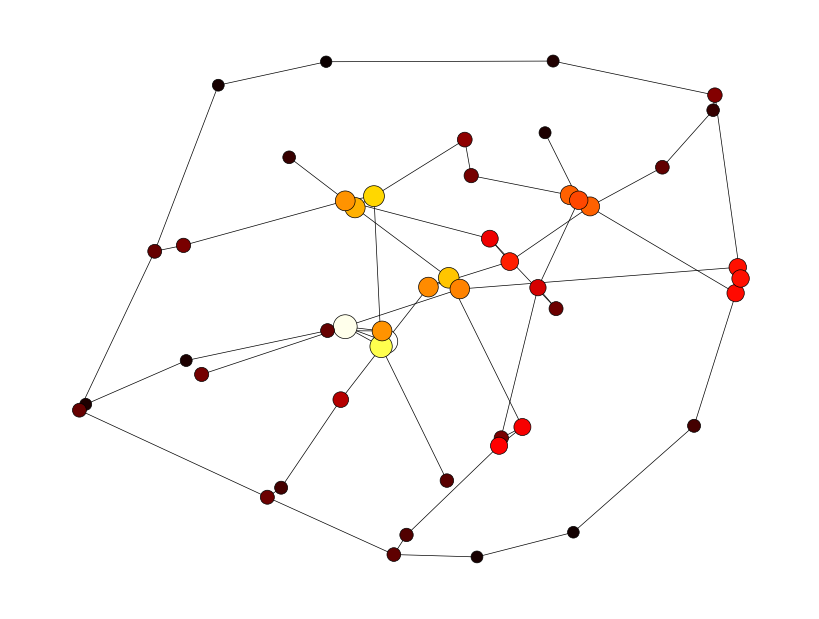

In [98]:
katz_c = katz_centrality(subG, 20, 1/4)
katz_c = katz_c / katz_c.max()
plt.figure(figsize=(8, 6))
nx.draw(subG,
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=katz_c*300,
        node_color=katz_c)
plt.show()

Here we can see how Katz centrality converges by the number of iterations.

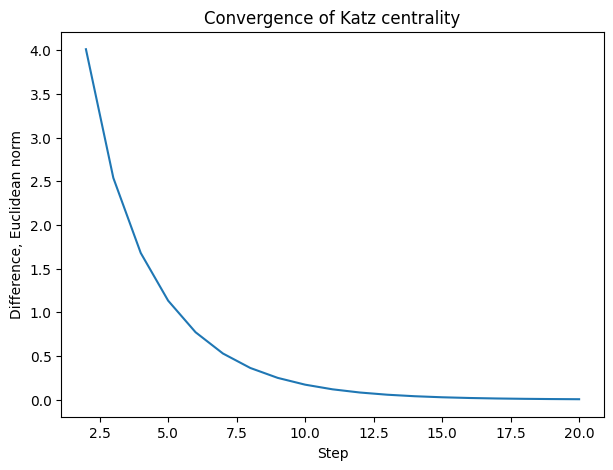

In [99]:
plt.figure(figsize=(7, 5))
convergence = []
old_katz = katz_centrality(G, 1, 0.2)
step_space = np.arange(2, 21)
for i in step_space:
    katz = katz_centrality(G, i, 0.2)
    convergence.append(np.linalg.norm(katz - old_katz))
    old_katz = katz.copy()
plt.plot(step_space, convergence)
plt.ylabel('Difference, Euclidean norm')
plt.xlabel('Step')
plt.title('Convergence of Katz centrality')
plt.show()

### Task 6. Eigenvector centrality (3 points)

Let us implement eigenvector centrality that can be interpreted as influence of a node. A centrality value of a node takes into account centrality values of its neighbors, that is

$$v_i = \frac{1}{\lambda}\sum_j A_{ij} v_j$$

or in the matrix form

$$Av = \lambda v$$

where $\lambda$ is the largest eigenvalue.

Write a function `eigenvector_centrality` that takes an adjacency matrix `A` and returns a np.array with nonnegative centrality values.

In [127]:
def eigenvector_centrality(A: np.array) -> np.array:
    """
    Calculate eigenvector centrality

    :param A: adjacency matric of graph
    :return: array of eigenvector centralities
    """
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Find the index of the largest eigenvalue
    largest_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    # Get the eigenvector corresponding to the largest eigenvalue
    principal_eigenvector = eigenvectors[:, largest_eigenvalue_index]

    # Eigenvectors are defined up to a sign, ensure non-negative values
    if principal_eigenvector.sum() < 0:
        principal_eigenvector = -principal_eigenvector

    return principal_eigenvector.real

In [132]:
eig_c = eigenvector_centrality(nx.to_numpy_array(G))
assert np.all(eig_c > 0)
eig_c = eigenvector_centrality(nx.to_numpy_array(subG))
assert np.all(eig_c > 0)
assert eig_c.shape == (49, )
assert eig_c[0].round(4) == 0.0204
assert eig_c[-1].round(4) == 0.0511
assert eig_c[25].round(4) == 0.0305 # Modified assertion

Let us draw the graph with eigenvector centrality visualization.

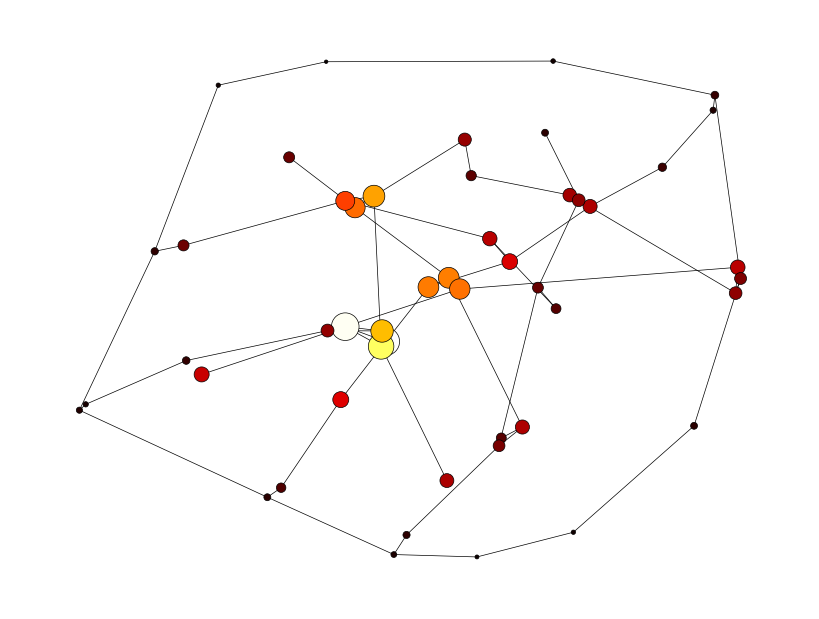

In [133]:
plt.figure(figsize=(8, 6))
nx.draw(subG,
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=eig_c/eig_c.max()*400,
        node_color=eig_c)
plt.show()

### Task 7. Centrality correlation (1 points)

Finally, let us see the relation between centralities. Calculate Pearson correlation coefficient and then we will draw scatter plots on pairs of centralities.

Write a function `pearson_correlation` that takes two np.arrays and returns Person correlation coefficient.

In [126]:
def pearson_correlation(i_vals: np.array, j_vals: np.array) -> float:
    """
    Calculate Pearson correlation coefficient

    :param i_vals: array of centralities
    :param j_vals: array of centralities
    :return: Pearson's correlation
    """
    i_mean = np.mean(i_vals)
    j_mean = np.mean(j_vals)
    numerator = np.sum((i_vals - i_mean) * (j_vals - j_mean))
    denominator = np.sqrt(np.sum((i_vals - i_mean) ** 2) * np.sum((j_vals - j_mean) ** 2))
    return numerator / denominator if denominator != 0 else 0.0


In [120]:
'''Check some coefficients'''
centvals = [
    ('Degree', list(nx.degree_centrality(G).values())),
    ('Closeness', list(nx.closeness_centrality(G).values())),
    ('Betweenness', list(nx.betweenness_centrality(G).values())),
    ('Katz', katz_centrality(G, 20, 1/5)),
    ('Eigenvector', eigenvector_centrality(nx.to_numpy_array(G)))
]
assert pearson_correlation(centvals[0][1], centvals[0][1]) == 1
assert round(pearson_correlation(centvals[4][1], centvals[2][1]), 4) == 0.3358
assert round(pearson_correlation(centvals[4][1], centvals[3][1]), 4) == 0.9169
assert round(pearson_correlation(centvals[0][1], centvals[1][1]), 4) == 0.7211
assert round(pearson_correlation(centvals[3][1], centvals[4][1]), 4) == 0.9169

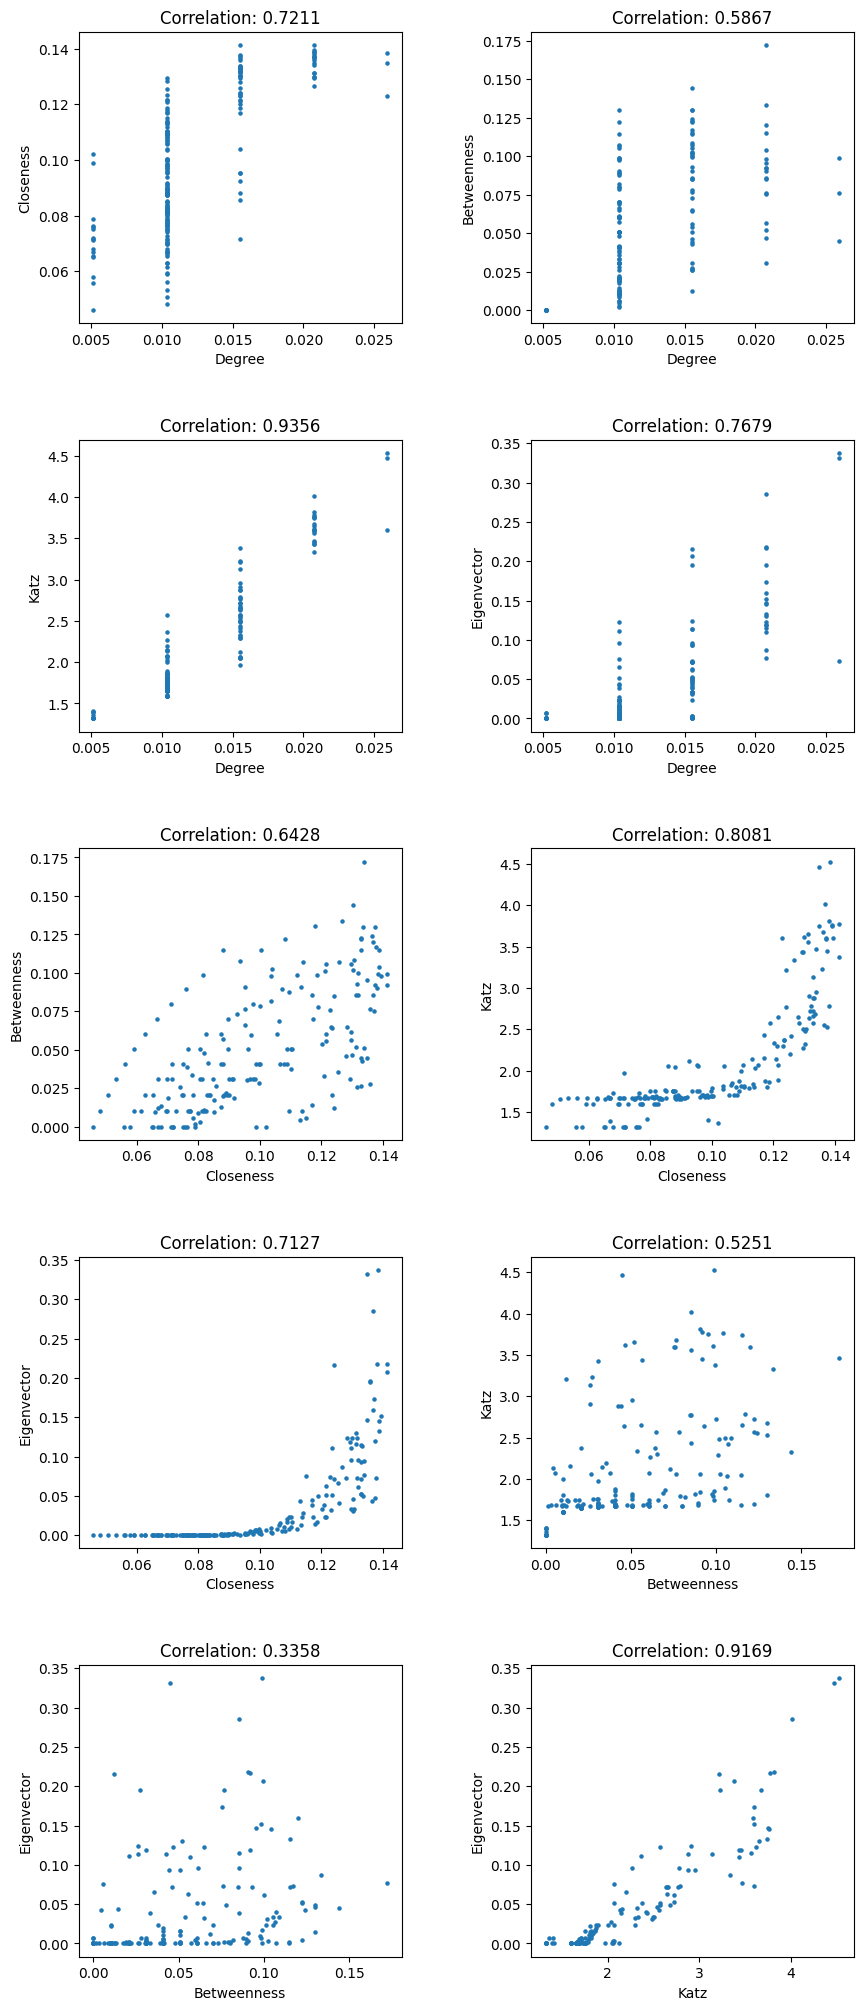

In [122]:
plt.figure(figsize=(2*5, 5*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(centvals)):
    for j in range(i + 1, len(centvals)):
        i_label, i_vals = centvals[i]
        j_label, j_vals = centvals[j]
        correlation = pearson_correlation(i_vals, j_vals)
        plt.subplot(5, 2, k)
        plt.scatter(i_vals, j_vals, s=5)
        plt.title('Correlation: {:.4f}'.format(correlation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1